In [1]:
"""
# Ridge Regression — NACA 4-Digit Airfoils

**Dataset:** AirfRANS (NACA 4-digit series only — 489 samples)
**Features:** Reynolds number, angle of attack, camber, camber position, thickness
**Target:** Lift-to-Drag ratio (L/D)

Ridge (L2 regularization) shrinks all coefficients toward zero but never eliminates them.
Key hyperparameter: **alpha** (regularization strength)
"""
from __future__ import annotations


from pathlib import Path
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error


# ─────────────────────────────────────────────────────────────────────────────
# Setup paths
# ─────────────────────────────────────────────────────────────────────────────
def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from: {start}")


REPO_ROOT = _find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


from src.config import DATA_DIR, RAW_DATASET_DIR
from src.tabular_data import load_airfrans_tabular_split


# ─────────────────────────────────────────────────────────────────────────────
# Load NACA 4-digit dataset
# ─────────────────────────────────────────────────────────────────────────────
csv_path = DATA_DIR / 'airfrans_dataset.csv'
manifest_path = RAW_DATASET_DIR / 'manifest.json'
task = 'full'


train_df, test_df = load_airfrans_tabular_split(csv_path, manifest_path, task=task)

# Clean NACA 4-digit features
feature_cols = ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']
target_col = 'L_D'

# Descriptive labels for plots
FEATURE_LABELS = {
    'Reynolds': 'Reynolds Number',
    'angle_of_attack_rad': 'Angle of Attack (rad)',
    'camber': 'Max Camber (%)',
    'camber_pos': 'Camber Position (tenths)',
    'thickness': 'Thickness (%)',
}


X_train = train_df[feature_cols]
y_train = np.asarray(train_df[target_col]).reshape(-1)
X_test = test_df[feature_cols]
y_test = np.asarray(test_df[target_col]).reshape(-1)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")


# ─────────────────────────────────────────────────────────────────────────────
# Preprocessing and evaluation function
# ─────────────────────────────────────────────────────────────────────────────
pre = Pipeline([
    ('scaler', StandardScaler()),
])


def fit_eval(alpha: float) -> dict:
    """Train Ridge with given alpha and return metrics."""
    model = Ridge(alpha=alpha, random_state=42)
    pipe = Pipeline([('pre', pre), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_train_pred = np.asarray(pipe.predict(X_train)).reshape(-1)
    y_test_pred = np.asarray(pipe.predict(X_test)).reshape(-1)
    
    n_train, p = X_train.shape
    n_test = len(y_test)
    
    r2_tr = float(r2_score(y_train, y_train_pred))
    r2_te = float(r2_score(y_test, y_test_pred))
    
    # Adjusted R²
    r2_adj_tr = 1 - (1 - r2_tr) * (n_train - 1) / (n_train - p - 1)
    r2_adj_te = 1 - (1 - r2_te) * (n_test - 1) / (n_test - p - 1)
    
    rmse_te = float(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    coef = np.asarray(pipe.named_steps['model'].coef_)
    l2_norm = float(np.linalg.norm(coef))
    
    return {
        'alpha': alpha,
        'r2_train': r2_tr,
        'r2_test': r2_te,
        'r2_adj_train': r2_adj_tr,
        'r2_adj_test': r2_adj_te,
        'rmse_test': rmse_te,
        'coef_l2': l2_norm,
        'coef': coef,
    }

Training samples: 378, Test samples: 111
Features: ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Alpha Sweep
# ─────────────────────────────────────────────────────────────────────────────
alphas = np.logspace(-4, 4, 35)
rows = [fit_eval(float(a)) for a in alphas]
res = pd.DataFrame(rows)

# Best result
best = res.loc[res['r2_adj_test'].idxmax()]
print(f"\nBest alpha = {best['alpha']:.2e}")
print(f"  Train R² adj = {best['r2_adj_train']:.4f}")
print(f"  Test R² adj  = {best['r2_adj_test']:.4f}")
print(f"  RMSE (test)  = {best['rmse_test']:.2f}")
print(f"  Coefficient L2 norm: {best['coef_l2']:.4f}")

res[['alpha', 'r2_adj_train', 'r2_adj_test', 'rmse_test', 'coef_l2']].sort_values('r2_adj_test', ascending=False).head(10)


Best alpha = 2.58e+01
  Train R² adj = 0.6657
  Test R² adj  = 0.5886
  RMSE (test)  = 21.18
  Coefficient L2 norm: 29.8023


,alpha,r2_adj_train,r2_adj_test,rmse_test,coef_l2
23,25.808615,0.665674,0.588617,21.183699,29.802283
24,44.366873,0.660694,0.587858,21.203231,28.456200
22,15.013107,0.667562,0.587707,21.207108,30.645958
21,8.733262,0.668247,0.586632,21.234751,31.159226
20,5.080218,0.668488,0.585801,21.256082,31.465842
19,2.955209,0.668572,0.585244,21.270374,31.647014
18,1.719072,0.668600,0.584894,21.279348,31.753373
17,1.000000,0.668610,0.584681,21.284795,31.815575
16,0.581709,0.668613,0.584554,21.288042,31.851872
15,0.338386,0.668615,0.584480,21.289957,31.873024


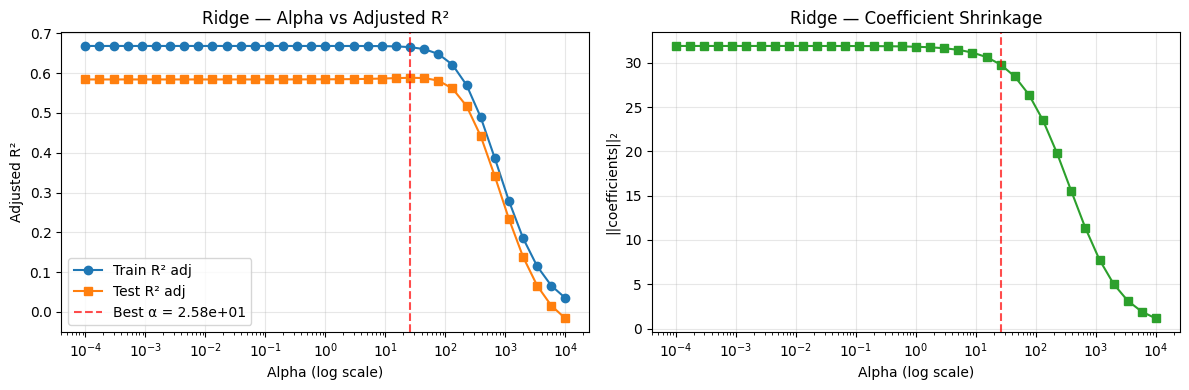


Observation: L2 norm decreases monotonically with alpha — Ridge never zeros coefficients.


In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Alpha vs R² Adjusted (with coefficient shrinkage)
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Left: R² vs alpha
ax[0].semilogx(res['alpha'], res['r2_adj_train'], 'o-', label='Train R² adj', color='tab:blue')
ax[0].semilogx(res['alpha'], res['r2_adj_test'], 's-', label='Test R² adj', color='tab:orange')
ax[0].axvline(best['alpha'], color='red', linestyle='--', alpha=0.7, label=f"Best α = {best['alpha']:.2e}")
ax[0].set_xlabel('Alpha (log scale)')
ax[0].set_ylabel('Adjusted R²')
ax[0].set_title('Ridge — Alpha vs Adjusted R²')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Right: Coefficient shrinkage
ax[1].semilogx(res['alpha'], res['coef_l2'], 's-', color='tab:green')
ax[1].axvline(best['alpha'], color='red', linestyle='--', alpha=0.7)
ax[1].set_xlabel('Alpha (log scale)')
ax[1].set_ylabel('||coefficients||₂')
ax[1].set_title('Ridge — Coefficient Shrinkage')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nObservation: L2 norm decreases monotonically with alpha — Ridge never zeros coefficients.")

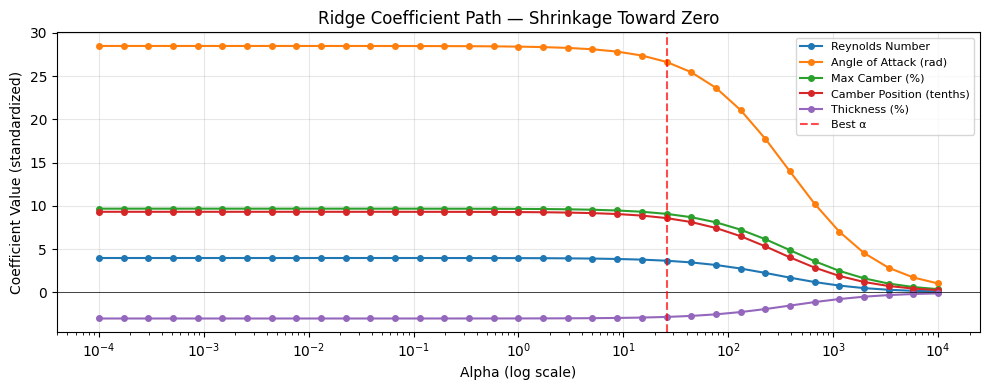


Coefficients at best alpha (standardized):
  Reynolds Number               : +3.6622
  Angle of Attack (rad)         : +26.6530
  Max Camber (%)                : +9.0823
  Camber Position (tenths)      : +8.5922
  Thickness (%)                 : -2.8400


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Coefficient Path (how each coefficient shrinks with alpha)
# ─────────────────────────────────────────────────────────────────────────────
coef_matrix = np.array([r['coef'] for r in rows])

fig, ax = plt.subplots(figsize=(10, 4))
for i, feat in enumerate(feature_cols):
    ax.semilogx(res['alpha'], coef_matrix[:, i], 'o-', label=FEATURE_LABELS.get(feat, feat), markersize=4)

ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(best['alpha'], color='red', linestyle='--', alpha=0.7, label=f"Best α")
ax.set_xlabel('Alpha (log scale)')
ax.set_ylabel('Coefficient Value (standardized)')
ax.set_title('Ridge Coefficient Path — Shrinkage Toward Zero')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Coefficients at best alpha
print("\nCoefficients at best alpha (standardized):")
for feat, c in zip(feature_cols, best['coef']):
    print(f"  {FEATURE_LABELS.get(feat, feat):30s}: {c:+.4f}")

---

## Conclusions (Ridge Only)

### Final Ridge Metrics (Best Observed)
- **Best alpha (sweep):** `alpha=25.808615`
- **Adjusted $R^2$ (train):** $0.665674$
- **Adjusted $R^2$ (test):** $0.588617$
- **Test RMSE:** $21.183699$
- **Coefficient L2 norm:** $29.802283$

### Key Deductions
1. **Ridge does not materially improve generalization here.** The best test $R^2_{adj}$ remains in the same band as other linear baselines, indicating model bias (linearity) is the primary limitation.
2. **Regularization mainly shrinks coefficients, not error.** As `alpha` increases, the coefficient L2 norm shrinks smoothly, but test $R^2_{adj}$ changes only slightly across a wide range of `alpha` values.
3. **Ridge keeps all features active.** Unlike Lasso, Ridge does not zero coefficients; it distributes weight across all 5 physically meaningful inputs.
